In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from src.perturbation import get_ecosystems_to_perturb_at_times_tstar, epsilon_k, theta
from src.n_forest import alpha

In [5]:
def deriv_forest(x, y, penalty_rate, args):
    """
    Calculate derivatives of x and y over time as per the Antonovsky & Korzukhin rule.
    
    INPUT:
    x            = value for x; density of young trees in ecosystem, typically between 0 and 4
    y            = value for y; density of old trees in ecosystem, typically between 0 and 4
    penalty_rate = penalty rate calculated by penalty function
    args         = tuple of 9 arguments

    Returns derivatives of x and y.
    """
    # Unpack arguments rho, gamma (not used), f, h, a1 and a2
    fertility, aging_rate, biotic_pump_young, mortality_old, biotic_pump_old, dist, beta_2, P_0 = args
    
    # Calculate derivatives
    dx = fertility * y - ((y - 1)**2 + 1) * x - aging_rate * x + biotic_pump_young * penalty_rate * x
    dy = aging_rate * x - mortality_old * y + biotic_pump_old * penalty_rate * y
    
    return dx, dy

In [6]:
def deriv_forest_perturbed(x, y, penalty_rate, epsilon, theta, args):
    """
    Calculate derivatives of x and y over time as per the Antonovsky & Korzukhin rule.
    
    INPUT:
    x            = value for x; density of young trees in ecosystem, typically between 0 and 4
    y            = value for y; density of old trees in ecosystem, typically between 0 and 4
    penalty_rate = penalty rate calculated by penalty function
    args         = tuple of 9 arguments

    Returns derivatives of x and y.
    """
    # Unpack arguments rho, gamma (not used), f, h, a1 and a2
    fertility, aging_rate, biotic_pump_young, mortality_old, biotic_pump_old, dist, beta_2, P_0 = args
    
    # Calculate derivatives
    dx = fertility * y - ((y - 1)**2 + 1) * x - aging_rate * x + biotic_pump_young * penalty_rate * x - epsilon * theta * x
    dy = aging_rate * x - mortality_old * y + biotic_pump_old * penalty_rate * y - epsilon * theta * y
    
    return dx, dy

In [7]:
def system_n_forests(x0s, y0s, args, perturbed = False, timesteps = 100, dt = 0.01, ecosystems_to_deforest = 2):
    """Solve the system of ODEs of the Antonovosky rule using forward Euler.

    Args:
        x0s: array of values for x, the density of young trees in the ecosystem; 
            typically between 0 and 4.
        y0s: array of values for y, the density of old trees in the ecosystem; 
            typically between 0 and 4.
        args: tuple of arguments needed for the derivation function
        timesteps: int, timesteps to iterate over; default 100
        dt: Delta time, default 0.01
        ecosystems_to_deforest: int, how many ecosystems should be deforested initially
    
    Returns:
        Two arrays of x and y values per time
    """
       
    assert (isinstance(args, (tuple, list, np.ndarray))),( 
            "Your args variable should be a list-like.")
    assert (len(args)== 8), ("Make sure you have all arguments needed included:"
                             " fertility, aging_rate,"
                             "biotic_pump_young,"
                             "mortality_old, biotic_pump_old, dist, beta_2, P_0.")
    assert len(x0s) == len(y0s), ("The input vector for the young and old trees" 
                                   "should be the same length.")
    
    n = len(x0s)
    x_vals = np.empty((n, 1))
    y_vals = np.empty((n, 1))
    
    
    
    if perturbed:
        
        # Choose networks to deforest; gets a list of instances the deforested ecosystems
        # Limit the timesteps at which forest can be deforested until timestep 40
        deforest_ecosystem_at_t : List[EcosystemDeforestTime] = \
            get_ecosystems_to_perturb_at_times_tstar(
                t_timesteps=int(40/dt),
                n_deforested_ecosystems=ecosystems_to_deforest,
                n_total_ecosystems=n, seed = None)

        # Get a list with the ids of the ecosystems that will be deforested
        deforest_ecosystem_ids = [ecosystem.ecosystem_id for ecosystem in deforest_ecosystem_at_t]

    for t in range(int(timesteps / dt)):
        
        penalties = alpha(x0s, y0s, dist=args[5]/(n-1), beta_2 = args[6],
                          P_0 = args[7])
        for i in range(n):
            
#             x_vals[i, t] = x0s[i]
#             y_vals[i, t] = y0s[i]
            
            if perturbed:
                
                # Checks if this ecosystem i will be deforested
                epsilon_i = epsilon_k(k=i, ecosytem_ids=deforest_ecosystem_ids)
                
                
                if epsilon_i:
                    # Get index of this ecosystem i in the list of deforested ecosystems to get the t_star 
                    t_star_ix = deforest_ecosystem_ids.index(i)
                    used_t_star = deforest_ecosystem_at_t[t_star_ix].t_star
                    
                    # Calculate theta using this t_star
                    theta_i = theta(t=t, t_star=used_t_star)
                    
                else:
                    theta_i = 0
    
                # Use epsilon and theta in the other derivative function when perturbing the system
                dx, dy = deriv_forest_perturbed(x0s[i], y0s[i], penalties[i], epsilon_i, theta_i, args)
                
            else:
                dx, dy = deriv_forest(x0s[i], y0s[i], penalties[i], args)
            
            x0s[i] += dx * dt
            y0s[i] += dy * dt
        
        x_vals[i] = x0s[-1]
        y_vals[i] = y0s[-1]
            
    if perturbed:   
        return x_vals, y_vals, deforest_ecosystem_ids
    
    else:
        return x_vals, y_vals


In [8]:
fertility = 4.2 #rho
aging_rate = 1 #f
biotic_pump_young = 1 #a1
mortality_old = 2 #h
biotic_pump_old = 0 #a2
dist = 900
beta_2 = 0.15
P_0 = 1.05

arguments = (fertility, aging_rate, biotic_pump_young, mortality_old, biotic_pump_old, dist, beta_2, P_0)

time = 100
dt = 0.01
n = 5


xs, ys, deforested = system_n_forests(np.random.uniform(0,4,n),np.ones(n)*2, arguments, perturbed = True, timesteps = time, dt = dt)

# for i, x in enumerate(xs):
#     plt.plot(np.arange(0, time, dt), x, label = f"Young trees in ecosystem {i+1}")
#     plt.plot(np.arange(0, time, dt), ys[i], label = f"Old trees in ecosystem {i+1}")
# plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
# plt.show()

In [9]:
print(xs)

[[1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.88992846e-26]]


In [16]:
simulations = 500
n = 10
time = 100
results = np.empty((simulations, 4))

hist_list = []
for i in range(simulations):
    xs, ys, deforested = system_n_forests(np.random.uniform(0,4,n), np.random.uniform(0,4,n), 
                                          arguments, perturbed = True, timesteps = time, dt= dt)
    for y in ys:
        if np.isclose(y, 0):
            hist_list.append(deforested[0])
            hist_list.append(deforested[1])
    
print(hist_list)

[4, 1, 4, 1, 4, 1, 5, 8, 5, 8, 6, 8, 6, 8, 8, 5, 8, 5, 1, 3, 1, 3, 1, 3, 7, 5, 7, 5, 1, 9, 1, 9, 1, 9, 7, 2, 9, 6, 9, 6, 9, 6, 8, 1, 8, 1, 6, 4, 6, 4, 6, 4, 5, 9, 5, 9, 5, 9, 5, 9, 6, 3, 1, 0, 1, 0, 3, 2, 3, 2, 3, 2, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 7, 8, 7, 8, 7, 8, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 2, 5, 2, 5, 5, 6, 5, 6, 1, 3, 1, 3, 9, 4, 9, 4, 9, 4, 9, 4, 9, 4, 9, 4, 9, 4, 9, 4, 4, 8, 4, 8, 4, 8, 4, 8, 7, 5, 7, 5, 7, 5, 2, 0, 2, 0, 2, 0, 9, 5, 9, 5, 9, 5, 9, 5, 9, 5, 9, 6, 9, 6, 2, 1, 2, 1, 2, 1, 4, 2, 4, 2, 0, 7, 0, 7, 7, 5, 7, 5, 7, 5, 9, 0, 9, 0, 9, 0, 5, 9, 5, 9, 2, 5, 6, 2, 6, 2, 1, 3, 1, 3, 1, 3, 3, 9, 3, 9, 3, 9, 8, 9, 8, 9, 1, 0, 1, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 6, 5, 6, 5, 2, 6, 2, 6, 7, 3, 7, 3, 6, 5, 6, 5, 5, 1, 5, 1, 5, 6, 5, 6, 9, 3, 9, 3, 9, 3, 7, 4, 7, 4, 7, 4, 7, 4, 7, 4, 3, 7, 3, 7, 3, 2, 3, 2, 3, 2, 5, 1, 5, 1, 5, 1, 5, 1, 5, 1, 5, 1, 5, 1, 5, 1, 5, 1, 3, 1, 3, 1, 4, 0, 4, 

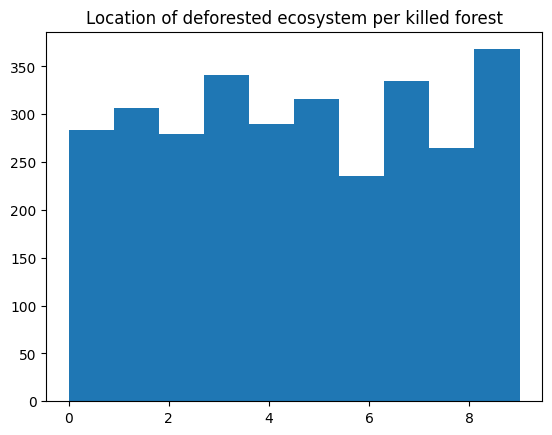

<Figure size 640x480 with 0 Axes>

In [18]:
plt.hist(hist_list)
plt.title("Location of deforested ecosystem per killed forest")
plt.show()
plt.savefig("../plots/histogram.png", dpi=300)

In [19]:
f= open("hist_data.txt","w+")
f.write(str(hist_list))
f.close()